# An Energy Balance Model of Titan's Hydroclimate
by Nicholas James Archambault, Juan M. Lora

Titan is the solar system's second largest moon, a world both familiar and eerily alien, where a hazy atmosphere conceals a surface topography of hydrocarbon dunes and methane rivers and seas. Frequently described as the solar system body most analogous to Earth, it is the destination of NASA’s Dragonfly mission, scheduled to arrive in 2034, which will deploy a rotorcraft to analyze samples of complex atmospheric chemistry and varied surface composition.

In this senior capstone project for the Department of Physics, we construct an energy balance model (EBM) to simulate and investigate Titan’s climate, specifically the mechanisms driving global energy and moisture transport. Titan is the only other world in the solar system to feature an active hydrological cycle, a process of constant interaction between the atmosphere, surface and subsurface that circulates and replenishes liquid methane through processes of evaporation and precipitation. One of Titan’s most intriguing unexplained features is the confinement of all filled lake and sea basins to latitudes poleward of 55 degrees. Such distribution, which leaves equatorial and mid latitudes arid, implies pole-to-pole transport of moisture governed by seasonal and orbital cycles. Given the polar concentration of surface liquid, Titan’s global relative humidity is much greater at high latitudes than low, in an inversion of the humidity profile observed on Earth. 

This project realizes a one-dimensional model of the latitudinal dependence of energetic and hydrological processes, allowing the sensitivity of their parameters to be explored at low computational costs. The model is calibrated on known climatological results for energy distribution on Earth, then applied to Titan and adjusted to understand the influence of certain free parameters whose true values are unknown. By numerically integrating differential equations that evaluate moist static energy flux and its relationship to solar heating, the Titan version accurately replicates known temperature, energy, and moisture profiles. Implementing a recursive feedback function, we show that the model permits the natural emergence of a convergent solution for the relative humidity profile, matching that observed by data. The sensitivity of this profile is also analyzed, and the physical processes behind its response explored. By illuminating the intuition behind the planetary constraints governing moisture distribution, the model provides a flexible, accessible starting point for further investigation of Titan’s energetic processes.

## Import Packages

We begin by importing the necessary packages and defining a variable, `planet`, that keeps track of which body, Earth or Titan, is being tested at the current iteration of the model. This step is a crucial component of producing clean code that does not require manual refinement of a bevy of planetary parameters each time the body is switched and the model run or tested.

In [2]:
planet = "Titan"


%pylab inline
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sympy as sy
import numpy.polynomial.polynomial as poly

Populating the interactive namespace from numpy and matplotlib


## Preliminary Calibration

Alexander Hayes of Cornell University has compiled data on Titan's orbital parameters for the past million years. Using this data, we can replicate the plots found in *Lora et al., 2014* of key orbital characteristics in order to understand oscillatory tendencies on kiloyear timescales that are influenced by orbital forcing cycles analogous to Earth's Milankovitch cycles.

All values below are plotted for the past million years of Titan's history.

In [3]:
# Read in data
orbit = pd.read_csv("Saturn_Orbital_Elements.csv", 
                    names = ["ecc", "inc", "w_p", "capom", "L_p", "obl", "w", "f", "M", "a", "L_s", "t"])

#### Eccentricity
A dimensionless quantity capturing the amount by which an elliptical orbit deviates from circularity.

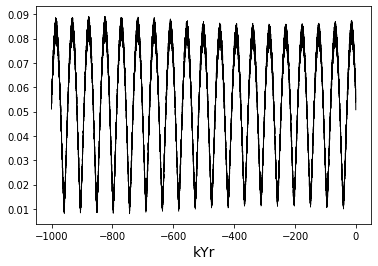

In [19]:
plt.figure()
plt.plot(orbit["t"].reindex(index = orbit["t"].index[::-1])/1000, 
         orbit["ecc"].reindex(index = orbit["ecc"].index[::-1]), 
         color = "black", 
         linewidth = "0.5")
plt.xlabel("kYr", fontsize = 14)
# plt.savefig("eccentricity.png", dpi=300)

Titan's orbit around Saturn appears to have varied in eccentricity between 0.01 and 0.09. 

#### Obliquity
Axial tilt; the angular difference between the rotational and orbital axes of a body.

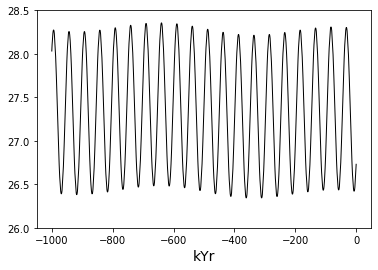

In [18]:
plt.figure()
plt.plot(orbit["t"].reindex(index = orbit["t"].index[::-1])/1000, 
         rad2deg(orbit["obl"].reindex(index = orbit["obl"].index[::-1])), 
         color = "black", 
         linewidth = "1")
plt.xlabel("kYr", fontsize = 14)

plt.ylim(26, 28.5)
# plt.savefig("obliquity.png", dpi=300)

Titan's obliquity has varied between roughly 26.4 and 28.3 degrees.

#### Semi-major Axis
Half of the major axis of an orbital ellipse.

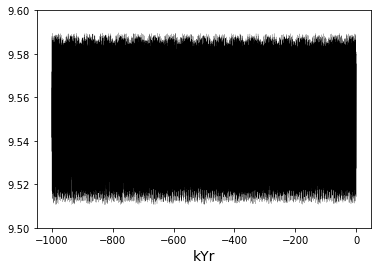

In [17]:
plt.figure()
plt.plot(orbit["t"].reindex(index = orbit["t"].index[::-1])/1000, 
         orbit["a"].reindex(index = orbit["a"].index[::-1]), 
         color = "black", 
         linewidth = "0.15")
plt.xlabel("kYr", fontsize = 14)
plt.ylim(9.5, 9.6)
# plt.savefig("semimajor.png", dpi=300)

The oscillatory frequency of semi-major axis is far greater than that of either eccentricity or obliquity. Titan's semi-major axis has varied between 9.51 and 9.59 AU.

#### Solar Longitude of Perihelion
The longitude at which a satellite's closest approach to the central body would occur if orbital inclination were zero. 

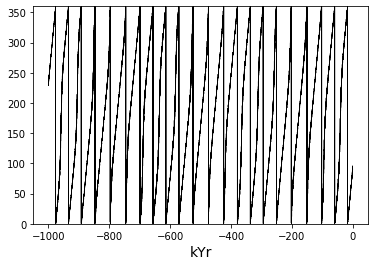

In [16]:
plt.figure()
plt.plot(orbit["t"].reindex(index = orbit["t"].index[::-1])/1000, 
         rad2deg(orbit["w_p"].reindex(index = orbit["w_p"].index[::-1])), 
         color = "black", 
         linewidth = "0.5")
plt.xlabel("kYr", fontsize = 14)

plt.ylim(0, 360)
# plt.savefig("perihelion.png", dpi = 300)

## Define Constants

The first step in building the EBM itself is defining its parameters, including the values of planetary constants for both Earth and Titan. The model will first be calibrated on Earth data to match, as closely as possible, known results produced in *Siler et al., 2018*. All constant values have been empirically identified for Earth, while some must be tested and imputed for Titan.

The model mesh is defined to have 1,000 nodes at which the differential equations will be solved. The latitudinal input `xin` represents the sine of latitude and is defined from -1 to 1, with endpoint values eliminated to avoid discontinuities.

Note that relative humidity is defined as a function for both bodies. On Earth, global relative humidity is accepted at around 0.8. On Titan, it has been shown to rise at the poles, where the majority of surface liquid lies. Defining relative humidity as a function -- even when that function is used to output a single value -- allows for flexibility in adjusted relative humidity within model later on.

In [4]:
# ODE function parameters
nodes = 1000
xin = arange(-0.999, 0.9991, 0.001) 

t = 4567       # [Millions years] age of Sun

In [5]:
# Earth constants
if planet == "Earth":
    cp = 1004           # [J kg-1 K-1]
    eps = 0.622         
    Lv = 2.45e6         # [J kg-1]
    e0 = 611.2          # [Pa]
    p0 = 1.013e5        # [Pa]
    g = 9.81            # [m s-2]
    Rv = 461.5          # [J kg-1]
    R = 6.37e6          # [m]
    rho = 1e3           # [kg m-3]
    rel_hum = 0.8
    dh_gms = 1.5e4      # [J kg-1]
    sigma = 0.3
    alpha = 0.3
    Q0 = 340.5          # [W m-2]
    D = 1.16e6          # [m2 s-1]
    m0 = 28             # [g mol-1]
    omega = 7.27e-5     # [rad s-1]
    T0 = 273.15         # [K]
    
    def RH(x):
        return 0.8*x**0
    
    
# Titan constants    
if planet == "Titan":
    cp = 1000
    eps = 0.571
    Lv = 5.5e5
    e0 = 10600
    p0 = 1.5e5
    g = 1.35
    Rv = 518.2
    R = 2.5747e6
    rho = 450
    sigma = 0.6
    alpha = 0.22
    Q0 = 3.75
    D = 2e3
    m0 = 28
    omega = 2*pi / (15.95 * 86400)
    T0 = 90.68
    

#     def RH(x, a, b, c):
#         return a - b*cos(c*x)

    def RH(x):
        return 0.5*x**0

Descriptions of the listed constants are found below.

   * **heat capacity** - *cp*

    The amount of heat that must be provided to a given mass of a substance to produce a unit Kelvin change in its temperature.


   * **mixing ratio** - *eps*   

    The amount of water vapor in a certain amount of dry air. For Earth, this ratio is given by the molecular mass of water over the mass of that of dry air. For Titan, it will be given by the mass of liquid methane over the mass of dry Titan air.


   * **latent heat of vaporization** - *Lv*

    The amount of heat that must be added to a liquid in order to transform a given quantity of that liquid into gas.


   * **saturation vapor pressure** - *e0*

    The pressure at which a vapor is in thermodynamic equilibrium with its condensed state. At higher pressures the vapor would condense into liquid.


   * **surface pressure** - *p0*

    Average atmospheric pressure at sea level.


   * **accel. due to gravity** *- g*

    The acceleration of an object in free fall in a vacuum.


   * **gas constant** - *Rv*

    The value, for a particular gas, of the universal gas constant *R = 8.31 [J mol-1 K-1]* divided by the gas' molecular mass.


   * **planetary radius** - *R*


   * **liquid density** - *rho*

    For Earth, water. For Titan, methane.


   * **relative humidity** - *rel_hum*

    A dimensionless ratio of vapor partial pressure over saturation vapor pressure.


   * **gross moist stability** - *dh_gms*

    A measure of the efficiency of convective circulation at transporting moist static energy.


   * **width of Hadley cell** - *sigma*

    The proportion of global latitude over which the Hadley cell atmospheric circulation extends.


   * **albedo** - *alpha*

    The proportion of diffuse incoming solar radiation reflected by a planetary surface.


   * **solar constant** - *Q0*

    The amount of incoming energy from sunlight. For Earth, typically accepted as ~$1362$. The cross-sectional area of the Earth heated by the Sun is given by $\pi R^2$, and the total surface area of the planet is given by $4\pi R^2$, where $R$ is Earth's radius. This means that the fraction of incoming insolation received by the Earth is $\frac{\pi R^2}{4\pi R^2}$, or $\frac{1}{4}$ of the solar constant. This results in a $Q0$ of $\frac{1362}{4} = 340.5$. 

    Insolation is based on a planet's distance from the Sun. Earth is $1$ AU away, while Saturn is ~$9.58$ AU away, on average. Insolation falls off with the inverse square of distance, so Titan, orbiting Saturn at a distance of ~$9.58$ AU, should receive $\frac{1}{9.58^2}(1362)$ watts of insolation. This value works out to $15$; dividing by four with the same geometrical conditions employed on Earth results in a $Q0$ value for Titan of $3.75$. 
    
    
   * **diffusion constant** - *D*
   
    A measure of atmospheric diffusivity.
   
   
   * **mean molecular mass** - *m0*
   
    A weighted average of the molecular mass of atmosphere based on the representative proportions of elements present
   
   
   * **rotation rate** - *omega*
   
    For Earth, how fast it spins on its axis. Titan is tidally locked in synchronous rotation with Saturn, meaning it always shows the same face to the planet. As such, Titan's rotation rate refers to the rate at which it completes one orbit of Saturn.
   
   
   * **triple point temperature** - *T0*
    
    The temperature at which a substance can exist in solid, liquid, and gaseous forms.



## Linearize Stefan-Boltzmann Law

Outgoing longwave radiation represents a linearization of the Stefan-Boltzmann law, which determines a blackbody's emissivity as a function of temperature. 

$j^* = \sigma T^4$

In the Stefan-Boltzmann law, $T$ is the temperature in Kelvin, $j^*$ the emissivity, and $\sigma$ the Boltzmann constant, $5.67 \times 10^{-8}$ Wm$^{-2}$K$^{-4}$.

For both Titan and Earth, we define an appropriate range of surface temperature and linearize the Stefan-Boltzmann law within that range, using linear regression to identify the proper slope and intercept for this approximation. 

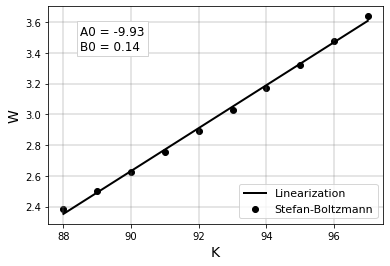

In [6]:
boltz = 5.67e-8 # [W m-2 K-4]

if planet == "Titan":
    # Temp. range: 88-98 K
    X = arange(88, 98).reshape(-1, 1)
    y = boltz*((X - 7.5)**4)   # Offset of 7.5 K between temperature at surface and top of atmosphere

if planet == "Earth":
    # Temp. range: 280-295 K
    X = arange(280, 295).reshape(-1, 1)
    y = boltz*((X - 30)**4)    # Offset of ~30 K between temperature at surface and top of atmosphere
    

# Instantiate regression object
lr = LinearRegression()

# Fit model; define A0 and B0
lr.fit(X, y)

B0 = lr.coef_[0][0]
A0 = lr.intercept_[0]
# Slope and intercept, respectively, of the linear approximation of the Stefan-Boltzmann law for power radiated by
# a blackbody -- in this case, insolation from the Sun.


if planet == "Titan":
    props = dict(boxstyle = 'square', facecolor = 'white', alpha = 1, edgecolor = "lightgray")
    plt.scatter(X, y, color = "black", marker = "o", label = "Stefan-Boltzmann")
    plt.plot(X, A0 + B0*X, color = "black", linewidth = 2, label = "Linearization")
    plt.xlabel("K", fontsize = 14)
    plt.ylabel("W", fontsize = 14)
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
    plt.legend(loc = "lower right", fontsize = 11)
    plt.text(88.5, 3.42, "A0 = {}\nB0 = {}".format(round(A0, 3), round(B0, 3)), backgroundcolor = "white", 
             fontsize = 12, bbox = props)

    # plt.savefig("sb_linearization_titan.png", dpi = 300)


if planet == "Earth":
    props = dict(boxstyle = 'square', facecolor = 'white', alpha = 1, edgecolor = "lightgray")
    plt.scatter(X, y, color = "black", marker = "o", label = "Stefan-Boltzmann")
    plt.plot(X, A0 + B0*X, color = "black", linewidth = 2, label = "Linearization")
    plt.xlabel("K", fontsize = 14)
    plt.ylabel("W", fontsize = 14)
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
    plt.legend(loc = "lower right", fontsize = 11)
    plt.text(281, 265, "A0 = {}\nB0 = {}".format(round(A0, 3), round(B0, 3)), backgroundcolor = "white", 
             fontsize = 12, bbox = props)
    
    # plt.savefig("sb_linearization_earth.png", dpi = 300)

## Solve for $a$ and $b$

The Clausius-Clapeyron relation gives the relationship between pressure and temperature for a substance as it transitions phases. 

$e_s = e_0 exp(\frac{L_v}{R_vT_o}) exp(\frac{-L_v}{R_vT})$

A 1980 approximation by Bolton simplified the above expression for water vapor to the form 
$e_s = e_0 exp(\frac{aT}{b + T})$
which provides a sound approximation for the Clausius-Clapeyron relation, assuming `L_v` is constant. 
Bolton established that appropriate and widely-accepted values for $a$ and $b$ for water on Earth are
$a = 17.67$ and $b = 243.5$˚C.

We fit a curve to derive the values for $a$ and $b$ in Kelvin for water on Earth and methane on Titan.

In [1]:
if planet == "Titan":
    # Define temperature range
    x = arange(88, 98, 2)
    # Define range for plot
    xx = np.linspace(88, 98)
    
if planet == "Earth":
    # Define temperature range
    x = arange(280, 295, 0.5)
    # Define range for plot
    xx = np.linspace(250, 320)

    
# Simplified CC
def CC(z):
    y = e0 * np.exp(Lv / (Rv*T0)) * np.exp(-Lv / (Rv*z))
    return y

y = CC(x)

# Bolton approximate form
def func(x, a, b):
    return e0 * np.exp((a*(x - T0))/(b + x))

# Fit
popt, pcov = curve_fit(func, x, y, p0 = (0, 0))

a = popt[0]
b = popt[1]

if planet == "Titan":
    plt.plot(xx, func(xx, *popt), color = "black", label = "Estimation")   # estimation
    plt.scatter(xx, e0 * np.exp(Lv / (Rv*T0)) * np.exp(-Lv / (Rv*xx)), marker = ".", color = "black",
               label = "Full Expression")   # full expression
    props = dict(boxstyle = 'square', facecolor = 'white', alpha = 1, edgecolor = "lightgray")
    plt.xlabel("K", fontsize = 14)
    plt.ylabel("Pa", fontsize = 14, labelpad = -0.5)
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
    plt.legend(loc = "lower right", fontsize = 11)
    plt.text(88.02, 22500, "a = {}\nb = -1.4e-05".format(round(a, 3), round(b, 3)), backgroundcolor = "white", 
             fontsize = 12, bbox = props)
    #plt.savefig("cc_estimation_methane.png", dpi = 300)
    
    
if planet == "Earth":
    plt.plot(xx, func(xx, *popt), color = "black", label = "Estimation")   # estimation
    plt.scatter(xx, e0 * np.exp(Lv / (Rv*T0)) * np.exp(-Lv / (Rv*xx)), marker = ".", color = "black",
               label = "Full Expression")   # full expression
    props = dict(boxstyle = 'square', facecolor = 'white', alpha = 1, edgecolor = "lightgray")
    plt.xlabel("K", fontsize = 14)
    plt.ylabel("Pa", fontsize = 14, labelpad = -0.5)
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
    plt.legend(loc = "lower right", fontsize = 11)
    plt.text(250.02, 8400, "a = {}\nb = -3.28e-05".format(round(a, 3), round(b, 3)), backgroundcolor = "white", 
             fontsize = 12, bbox = props)
    #plt.savefig("cc_estimation_water.png", dpi = 300)

NameError: name 'planet' is not defined

## Relative Humidity

We attempt to encode a non-constant relative humidity function dependent on latitude. The Earth model, based on the work of *Siler et al. 2018*, defines relative humidity as a global constant of 0.8.  We identify functions of the form $D + Acos(Bx)$ that with shapes that fall within the range of Titan's sinusoidal relative humidity profile, as shown in *Lora & Ádámkovics, 2017*. 

In [10]:
# List values that will yield permutations of formula which fall within range
perm = list(permutations([0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 
                          0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 
                          1.7, 1.8, 1.9, 2], 3))

# Define testing function
def tester(a, b, c):
    return a - b*cos(c*xin)

# Collect permutations
results = []
for i in perm:
    results.append(tester(*i))
    
# Transform to dataframe
col = pd.Series(perm)
col2 = pd.Series(results)

r = pd.concat([col, col2], axis = 1)
r = r.rename(columns = {0:"perm", 1:"values"})

In [11]:
# Create new columns
r["maxes"] = r["values"].apply(max, 1)
r["mins"] = r["values"].apply(min, 1)
r["eqs"] = r["values"].apply(lambda l: l[1000])
r["poles"] = r["values"].apply(lambda l: l[0])

# Eliminate permutations whose maxes exceed 1 or whose mins dip below 0.5, in line with empirical results
r = r[r["maxes"] < 1]
r = r[r["mins"] >= 0.5]

# Polar values should be high --- above 0.9
r = r[r["poles"] > 0.9]

# Equatorial values should be low --- no greater than 0.7
r = r[r["eqs"] < 0.7]

final = r
final = final.reset_index().drop("index", axis = 1)

## Define EBM

We now define the EBM function which solves a boundary value problem for moist static energy across a body's surface.

In [12]:
def MEBMfun(x, y):
    # y[0] ; dy0 = temperature (degC) ; dtemp/dx
    # y[1] ; dy1 = Moist static energy (MSE) flux ; dFlux/dx
    
    esat = e0*exp(a*(y[0] - T0)/(b + y[0]))       # Bolton approximate form of saturation vapor pressure
    esat_deriv = esat*a*(T0 + b)/((b + y[0])**2)  # Derivative of above expression
    
    rel_hum = RH(x)
    
    fac1 = 1/(cp + (eps*rel_hum*Lv/p0)*esat_deriv)   # Equivalent to 1/(dh/dT); denominator is cp + q*dq/dx
    
    # Legendre polynomial
    S = 1 - 0.241*(3*x**2 - 1)
    
    # Insolation expression denoting the amount of incoming solar energy
    Src = Q0*S*(1 - alpha)

    # Outgoing longwave radition expression that incorporates linearization of Stefan-Boltzmann law
    Snk = (A0 + B0*(y[0]))
    
    # Net solar forcing
    SrcSnk = Src - Snk 

    # dTemp/dx
    dy0 = (-g/(2*pi*D*p0))*(1/(1 - x**2))*fac1*y[1] 
    
    # dFlux/dx
    dy1 = 2*pi*(R**2)*SrcSnk

    # Properly align output with specifications required by solveBVP() function
    output = np.vstack((dy0, dy1))
    
    return(output)

# Boundary conditions
def bc(ya, yb):
    # MSE y[1] flux goes to 0 at poles: there can be no poleward transport at poles.
    # Function defines values going to 0 at boundary conditions 'a' and 'b'
    
    return np.array([ya[1], yb[1]])

## Define Hydrological Function

Next, we define the hydrological function built on top of the EBM function which will spit out key diagnostic data of the global climate system and allow trends in moisture and energy distribution to be visualized and better understood.

In [13]:
def hydrofunc(x, temp, coeff): 

    esat = e0*exp(a*(temp - T0)/(b + temp))    
    esat_deriv = esat * (a*(b + T0) / (b + temp)**2)
    
    rel_hum = RH(xin)
    
    # Specific humidity [kg kg-1] --- dimensionless ratio of the mass of vapor to the total mass of the system
    q = rel_hum*(eps/p0)*esat
    
    # Moist static energy [J kg-1] --- Thermodynamic variable calculated by adiabatically
    h = cp*(temp) + Lv*q
    
    # Poleward flux of MSE
    flux = (-2/g)*pi*p0*D*(1-(x**2))*np.gradient(h, x) # [W] 
    
    # Weighting function that partitions Hadley cell and eddy effects
    wt = 1 - exp(-(x**2)/sigma**2) 
    
    # Moist static energy at equator
    heq = max(h)
    
    # Gross moist stability, which governs the efficiency of convective moisture transport by latitude
    dh_gms = coeff*heq
    
    # Flux from Hadley cell
    f_hc = (1 - wt)*flux
    
    # Mass transport from Hadley cell
    V = f_hc / (heq + dh_gms - h)
    
    V[0] = 0
    V[len(V) - 1] = 0
    
    # Latent heat flux from eddies
    f_lh_eddy = wt*(-2/g)*pi*p0*D*(1-(x**2))*np.gradient(Lv*q, x)
    
    # Latent heat flux from Hadley cell
    f_lh_hadley = -Lv*V*q
    ''''''
    # Total latent heat flux: flux from surface to atmosphere associated with surface-level evaporation and
    # atmospheric condensation
    f_lh = f_lh_eddy + f_lh_hadley
    
    # Dry static heat flux: total flux minus latent heat flux
    f_ds = flux - f_lh
    
    # Divergence of latent heat flux
    div_lh = 1/(2*pi*(R**2))*np.gradient(f_lh, x)
    
    div_lh[0:1] = div_lh[2]
    div_lh[-2:] = div_lh[-3] 
    
    
    div_MSE = 1/(2*pi*(R**2))*np.gradient(flux, x)
    div_MSE[0:1] = div_MSE[2]
    div_MSE[-2:] = div_MSE[-3]
    
    # Evaporation minus precipitation per year
    emp = div_lh/(Lv*rho)*pi*1e7 
    
    # Convert xin to latitude
    lat = rad2deg(arcsin(x))
    
    data_out = {"lat":lat, "temp":temp, 'MSE_J_kg':h, 'EminusP_m_yr':emp, 'mseFlux_W':flux, 'latentFlux_W':f_lh, 
                'sensibleFlux_W':f_ds, 'latentEddyFlux_W':f_lh_eddy, 'latentHadleyFlux_W':f_lh_hadley, 
                'LHFlux_Div':div_lh, 'MSEFlux_Div':div_MSE}
    
    output = pd.DataFrame(data = data_out)

    return(output)

## Run Model

In [ ]:
# Provide initial guess of zeros matrix
init_guess = np.zeros(shape = (2, xin.size))

# Solve model
sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)

# Call 'hydrofunc()' with xin, temperature, and GMS coefficient as args
hydro = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)

#### Temperature plot

In [ ]:
if planet == "Titan":
    plt.plot(hydro["lat"], hydro["temp"], color = "black", linewidth = 1.5)
    plt.ylabel("K", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_T_temp.png", dpi=200)
    
if planet == "Earth":
    plt.plot(hydro["lat"], hydro["temp"], color = "black", linewidth = 1.5)
    plt.ylabel("K", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_Earth_temp.png", dpi=200)

#### Latent heat plot

In [ ]:
if planet == "Titan":
    plt.plot(hydro["lat"], hydro["latentFlux_W"] / 1e12, color = "black", linewidth = 1.5)
    plt.ylabel(r"W (x 10$^{12}$)", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_T_lh.png", dpi=200)
    
if planet == "Earth":
    plt.plot(hydro["lat"], hydro["latentFlux_W"] / 1e12, color = "black", linewidth = 1.5)
    plt.ylabel(r"W (x 10$^{12}$)", fontsize = 14, labelpad = -7)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_Earth_lh.png", dpi=200)

#### Moist static energy plot

In [ ]:
if planet == "Titan":
    plt.plot(hydro["lat"], hydro["MSE_J_kg"] / 1e3, color = "black", linewidth = 1.5)
    plt.ylabel(r"J kg$^{-1}$ (x $10^{3})$", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_T_mse.png", dpi=200)
    
if planet == "Earth":
    plt.plot(hydro["lat"], hydro["MSE_J_kg"] / 1e3, color = "black", linewidth = 1.5)
    plt.ylabel(r"J kg$^{-1}$ (x $10^{3})$", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_Earth_mse.png", dpi=200)

#### Net precipitation plot

In [ ]:
if planet == "Titan":
    plt.plot(hydro["lat"], hydro["EminusP_m_yr"], color = "black", linewidth = 1.5)
    plt.ylabel(r"m year$^{-1}$", fontsize = 13, labelpad = -2.5)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_T_emp.png", dpi=200)
    
if planet == "Earth":
    plt.plot(hydro["lat"], hydro["EminusP_m_yr"], color = "black", linewidth = 1.5)
    plt.ylabel(r"m year$^{-1}$", fontsize = 14, labelpad = -1)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_Earth_emp.png", dpi=200)

#### Moist static energy flux plot

In [ ]:
if planet == "Titan":
    plt.plot(hydro["lat"], hydro["mseFlux_W"] / 1e13, color = "black", linewidth = 1.5)
    plt.ylabel(r"W (x 10$^{13}$)", fontsize = 14, labelpad = -3)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_T_mse_flux.png", dpi=200)
    
if planet == "Earth":
    plt.plot(hydro["lat"], hydro["mseFlux_W"] / 1e13, color = "black", linewidth = 1.5)
    plt.ylabel(r"W (x 10$^{13}$)", fontsize = 14, labelpad = -3)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_Earth_mse_flux.png", dpi=200)

#### MSE flux divergence plot

In [ ]:
if planet == "Titan":
    plt.plot(hydro["lat"], hydro["MSEFlux_Div"], color = "black", linewidth = 1.5)
    plt.ylabel("W", fontsize = 14, labelpad = -2)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
    plt.savefig("baseline_T_div.png", dpi=200)
    
if planet == "Earth":
    plt.plot(hydro["lat"], hydro["MSEFlux_Div"], color = "black", linewidth = 1.5)
    plt.ylabel("W", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
#     plt.savefig("baseline_Earth_div.png", dpi=200)

## Sensitivity Tests

Test the sensitivities of model parameters and how they propagate through the system to affect global climate. 

### Relative Humidity
We attempt to identify the compelling factors differentiating viable relative humidity profiles from those that break the model.

In [ ]:
# Round values
final["diffs"] = [round(final["perm"][i][0] - final["perm"][i][1], 1) for i in range(final.shape[0])]

# Run model with all viable permutations; plot results
hold = []
for i in final.perm:
    def RH(x):
        return i[0] - i[1]*cos(i[2]*x)
    
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)
    
    hold.append(out)

titles = ["Temperature", "Latent Heat Flux", "Moist Static Energy", "Evaporation Minus Precipitation", 
              "Moist Static Energy Flux", "Moist Static Energy Flux Divergence"]

cols = ["temp", "latentFlux_W", "MSE_J_kg", "EminusP_m_yr", "mseFlux_W", "MSEFlux_Div"]

ylabels = ["K", "W", r"J kg$^{-1}$", r"m year$^{-1}$", "W", "W"]
    
fig = plt.figure(figsize = (12,15))
fig.text(0.25, 0.08, "Latitude", fontsize = 14)
fig.text(0.71, 0.08, "Latitude", fontsize = 14)

for i in range(len(titles)):
    subplot(3, 2, i + 1)
    for output in range(len(hold)):
        plt.plot(hold[output]["lat"], hold[output][str(cols[i])], color = "black", linewidth = 1.5)
    
        plt.title(titles[i], fontsize = 15)
        plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
        plt.ylabel(ylabels[i], fontsize = 14)
        plt.xticks([-90, -60, -30, 0, 30, 60, 90])
        plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

#### Latent heat plot

In [ ]:
for i in range(len(hold)):
    plt.plot(hold[i]["lat"], hold[i]["latentFlux_W"]/1e12, color = "black", linewidth = 1.5)
    plt.ylabel("W (x 10$^{12}$)", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("RH_latent_all.png", dpi=300)

#### Temperature plot

In [ ]:
for i in range(len(hold)):
    plt.plot(hold[i]["lat"], hold[i]["temp"], color = "black", linewidth = 1.5)
    plt.ylabel("K", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("RH_temp_all.png", dpi = 300)

#### MSE plot

In [ ]:
for i in range(len(hold)):
    plt.plot(hold[i]["lat"], hold[i]["MSE_J_kg"]/1e3, color = "black", linewidth = 1.5)
    plt.ylabel("J kg$^{-1}$ (x 10$^3$)", fontsize = 11)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("RH_mse_all.png", dpi = 300)

#### Net precipitation plot

In [ ]:
for i in range(len(hold)):
    plt.plot(hold[i]["lat"], hold[i]["EminusP_m_yr"], color = "black", linewidth = 1.5)
    plt.ylabel("m year$^{-1}$", fontsize = 11, labelpad = -6)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("RH_emp_all.png", dpi = 300)

#### MSE flux plot

In [ ]:
for i in range(len(hold)):
    plt.plot(hold[i]["lat"], hold[i]["mseFlux_W"]/1e12, color = "black", linewidth = 1.5)
    plt.ylabel("W (x 10$^{12}$)", fontsize = 14, labelpad = -2)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("RH_mse_flux_all.png", dpi = 300)

#### MSE flux divergence plot

In [ ]:
for i in range(len(hold)):
    plt.plot(hold[i]["lat"], hold[i]["MSEFlux_Div"], color = "black", linewidth = 1.5)
    plt.ylabel("W", fontsize = 14)
    plt.xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("RH_div_all.png", dpi = 300)

In [ ]:
# Define list of permutations that produce viable model results under defined parameters; run model and plot results
good = []
for i in range(len(hold)):
    if hold[i]["MSE_J_kg"][999] > hold[i]["MSE_J_kg"][1998]:
        good.append(i)
        
yes = final.loc[good]

hold_yes = []
for i in yes.perm:
    def RH(x):
        return i[0] - i[1]*cos(i[2]*x)
    
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)
    
    hold_yes.append(out)

titles = ["Temperature", "Latent Heat Flux", "Moist Static Energy", "Evaporation Minus Precipitation", 
              "Moist Static Energy Flux", "Moist Static Energy Flux Divergence"]

cols = ["temp", "latentFlux_W", "MSE_J_kg", "EminusP_m_yr", "mseFlux_W", "MSEFlux_Div"]


ylabels = ["K", r"W (x 10$^{12}$)", r"J kg$^{-1}$ (x $10^{3})$", r"m year$^{-1}$", r"W (x 10$^{12}$)", "W"]
    
fig = plt.figure(figsize = (12,15))
fig.text(0.25, 0.08, "Latitude", fontsize = 14)
fig.text(0.71, 0.08, "Latitude", fontsize = 14)

for i in range(len(titles)):
    subplot(3, 2, i + 1)
    for output in range(len(hold_yes)):
        if i == 1:
            plt.plot(hold[output]["lat"], hold_yes[output][str(cols[i])]/1e12, color = "black", linewidth = 1.5)
        elif i == 2:
            plt.plot(hold[output]["lat"], hold_yes[output][str(cols[i])]/1e3, color = "black", linewidth = 1.5)
        elif i == 4:
            plt.plot(hold[output]["lat"], hold_yes[output][str(cols[i])]/1e12, color = "black", linewidth = 1.5)
        else:
            plt.plot(hold[output]["lat"], hold_yes[output][str(cols[i])], color = "black", linewidth = 1.5)
    
        plt.title(titles[i], fontsize = 15)
        plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
        plt.ylabel(ylabels[i], fontsize = 14)
        plt.xticks([-90, -60, -30, 0, 30, 60, 90])
        plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
# plt.savefig("yes_plots_RH.png", dpi = 300)

In [ ]:
# Repeat for those permutations whose profiles actually mirror Titan profile (high RH at poles)
best = yes.loc[yes.maxes > 0.96]

hold_best = []
for i in best.perm:
    def RH(x):
        return i[0] - i[1]*cos(i[2]*x)
    
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)
    
    hold_best.append(out)

titles = ["Temperature", "Latent Heat Flux", "Moist Static Energy", "Evaporation Minus Precipitation", 
              "Moist Static Energy Flux", "Moist Static Energy Flux Divergence"]

cols = ["temp", "latentFlux_W", "MSE_J_kg", "EminusP_m_yr", "mseFlux_W", "MSEFlux_Div"]

ylabels = ["K", "W", r"J kg$^{-1}$", r"m year$^{-1}$", "W", "W"]
    
fig = plt.figure(figsize = (12,15))
fig.text(0.25, 0.08, "Latitude", fontsize = 14)
fig.text(0.71, 0.08, "Latitude", fontsize = 14)

for i in range(len(titles)):
    subplot(3, 2, i + 1)
    for output in range(len(hold_best)):
        plt.plot(hold[output]["lat"], hold_best[output][str(cols[i])], color = "black", linewidth = 1.5)
    
        plt.title(titles[i], fontsize = 15)
        plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
        plt.ylabel(ylabels[i], fontsize = 14)
        plt.xticks([-90, -60, -30, 0, 30, 60, 90])
        plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

### Sigma
The sigma value represents the latitudinal extent of the Hadley cell. How does the model respond to changing sigma values?

In [ ]:
# Define range
sigma_range = arange(0.3, 0.95, 0.1)

# Define lists to hold results
emp_results_sigma = []
lh_results_sigma = []
temp_results_sigma = []
mse_results_sigma = []
mse_flux_results_sigma = []
div_results_sigma = []

# Run model with changing sigma
for i in sigma_range:
    sigma = i
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)
    
    emp_results_sigma.append(out["EminusP_m_yr"])
    lh_results_sigma.append(out["latentFlux_W"])
    temp_results_sigma.append(out["temp"])
    mse_results_sigma.append(out["MSE_J_kg"])
    mse_flux_results_sigma.append(out["mseFlux_W"])
    div_results_sigma.append(out["MSEFlux_Div"])

#### Latent heat plot

In [ ]:
plt.ylabel("W (x 10$^{12}$)", fontsize = 14)
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])

for i in range(0, len(lh_results_sigma)):
    if i == 0:
        plt.plot(rad2deg(arcsin(xin)), lh_results_sigma[i]/1e12, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == 3:
        plt.plot(rad2deg(arcsin(xin)), lh_results_sigma[i]/1e12, color = "black", linewidth = 2)
    elif i == 6:
        plt.plot(rad2deg(arcsin(xin)), lh_results_sigma[i]/1e12, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), lh_results_sigma[i]/1e12, color = "gray", alpha = 0.8, linestyle = (0, (5, 1)))
        
# plt.savefig("sigma_latent_heat.png", dpi = 300)

#### Net precipitation plot

In [ ]:
plt.ylabel("m year$^{-1}$", fontsize = 14, labelpad = -1.6)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)


for i in range(0, len(emp_results_sigma)):
    if i == 0:
        plt.plot(rad2deg(arcsin(xin)), emp_results_sigma[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == 3:
        plt.plot(rad2deg(arcsin(xin)), emp_results_sigma[i], color = "black", linewidth = 2)
    elif i == 6:
        plt.plot(rad2deg(arcsin(xin)), emp_results_sigma[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), emp_results_sigma[i], color = "gray", alpha = 0.8, linestyle = (0, (5, 1)))
        
# plt.savefig("sigma_emp.png", dpi = 300)

#### Temperature plot

In [ ]:
plt.ylabel("K", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

leg_handles = [Line2D([], [], color='darkblue', ls='--', label = r'$\sigma$ = 0.3'),
              Line2D([], [], color='darkred', ls='--', label = r'$\sigma$ = 0.9'),
              Line2D([], [], color='black', ls='-', label = r'$\bf{\sigma = 0.6}$ $\bf{(Titan)}$')]

plt.legend(loc = "upper left", handles = leg_handles, fontsize = "small")

for i in range(0, len(temp_results_sigma)):
    if i == 0:
        plt.plot(rad2deg(arcsin(xin)), temp_results_sigma[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == 3:
        plt.plot(rad2deg(arcsin(xin)), temp_results_sigma[i], color = "black", linewidth = 2)
    elif i == 6:
        plt.plot(rad2deg(arcsin(xin)), temp_results_sigma[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), temp_results_sigma[i], color = "gray", alpha = 0.8, linestyle = (0, (5, 1)))
        
# plt.savefig("sigma_temp.png", dpi = 300)

#### MSE plot

In [ ]:
plt.ylabel(r"J kg$^{-1}$ (x 10$^3$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)


for i in range(0, len(temp_results_sigma)):
    if i == 0:
        plt.plot(rad2deg(arcsin(xin)), mse_results_sigma[i]/1e3, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == 3:
        plt.plot(rad2deg(arcsin(xin)), mse_results_sigma[i]/1e3, color = "black", linewidth = 2)
    elif i == 6:
        plt.plot(rad2deg(arcsin(xin)), mse_results_sigma[i]/1e3, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), mse_results_sigma[i]/1e3, color = "gray", alpha = 0.8, linestyle = (0, (5, 1)))
        
# plt.savefig("sigma_mse.png", dpi = 300)

#### MSE flux plot

In [ ]:
plt.ylabel("W (x 10$^{12}$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)



for i in range(0, len(temp_results_sigma)):
    if i == 0:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_sigma[i]/1e12, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == 3:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_sigma[i]/1e12, color = "black", linewidth = 2)
    elif i == 6:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_sigma[i]/1e12, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_sigma[i]/1e12, color = "gray", alpha = 0.8, linestyle = (0, (5, 1)))
        
# plt.savefig("sigma_mse_flux.png", dpi = 300)

#### MSE flux divergence plot

In [ ]:
plt.ylabel("W", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)



for i in range(0, len(temp_results_sigma)):
    if i == 0:
        plt.plot(rad2deg(arcsin(xin)), div_results_sigma[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == 3:
        plt.plot(rad2deg(arcsin(xin)), div_results_sigma[i], color = "black", linewidth = 2)
    elif i == 6:
        plt.plot(rad2deg(arcsin(xin)), div_results_sigma[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), div_results_sigma[i], color = "gray", alpha = 0.8, linestyle = (0, (5, 1)))
        
plt.savefig("sigma_div.png", dpi = 300)

### Gross moist stability coefficient
The gross moist stability $\Gamma$ is given by a coefficient $\lambda$ multiplied by the maximum moist static energy.

In [ ]:
# Define range -- accepted value is 1.06
gms_range = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 1.06]

emp_results_gms = []
lh_results_gms = []
mse_flux_results_gms = []
temp_results_gms = []
mse_results_gms = []
div_results_gms = []

for i in gms_range:
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = i)
    
    emp_results_gms.append(out["EminusP_m_yr"])
    lh_results_gms.append(out["latentFlux_W"])
    mse_flux_results_gms.append(out["mseFlux_W"])
    temp_results_gms.append(out["temp"])
    mse_results_gms.append(out["MSE_J_kg"])
    div_results_gms.append(out["MSEFlux_Div"])  

#### Latent heat plot

In [ ]:
plt.ylabel("W (x 10$^{12}$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)



for i in range(0, len(lh_results_gms)):
    
    if i == (len(lh_results_gms) - 1):
        plt.plot(rad2deg(arcsin(xin)), lh_results_gms[i]/1e12, color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), lh_results_gms[i]/1e12, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(lh_results_gms) - 2):
        plt.plot(rad2deg(arcsin(xin)), lh_results_gms[i]/1e12, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), lh_results_gms[i]/1e12, color = "gray", linestyle = (0, (5, 1)), 
                 alpha = 0.8)
        
# plt.savefig("gms_latent.png", dpi = 300)

#### Net precipitation plot

In [ ]:
plt.ylabel("m year$^{-1}$", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(lh_results_gms)):
    
    if i == (len(lh_results_gms) - 1):
        plt.plot(rad2deg(arcsin(xin)), emp_results_gms[i], color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), emp_results_gms[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(lh_results_gms) - 2):
        plt.plot(rad2deg(arcsin(xin)), emp_results_gms[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), emp_results_gms[i], color = "gray", linestyle = (0, (5, 1)), 
                 alpha = 0.8)
        
# plt.savefig("gms_emp.png", dpi = 300)

#### MSE flux plot

In [ ]:
plt.ylabel("W (x 10$^{12}$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(lh_results_gms)):
    
    if i == (len(lh_results_gms) - 1):
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_gms[i]/1e12, color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_gms[i]/1e12, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(lh_results_gms) - 2):
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_gms[i]/1e12, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_gms[i]/1e12, color = "gray", linestyle = (0, (5, 1)), 
                 alpha = 0.8)
        
# plt.savefig("gms_mse_flux.png", dpi = 300)

#### Temperature plot

In [ ]:
plt.ylabel("K", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

leg_handles = [Line2D([], [], color='black', ls='-', label = "$\lambda$ = 1.06"),
              Line2D([], [], color='gray', ls='--', label = "0 < $\lambda$ < 2"),
              Line2D([], [], color='darkblue', ls='--', label = "$\lambda$ = 0"),
              Line2D([], [], color='darkred', ls='--', label = "$\lambda$ = 2")]

plt.legend(loc = "upper left", handles = leg_handles, fontsize = "small")

for i in range(0, len(lh_results_gms)):
    
    if i == (len(lh_results_gms) - 1):
        plt.plot(rad2deg(arcsin(xin)), temp_results_gms[i], color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), temp_results_gms[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(lh_results_gms) - 2):
        plt.plot(rad2deg(arcsin(xin)), temp_results_gms[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), temp_results_gms[i], color = "gray", linestyle = (0, (5, 1)), 
                 alpha = 0.8)
        
# plt.savefig("gms_temp.png", dpi = 300)

#### MSE plot

In [ ]:
plt.ylabel("J kg$^{-1}$ (x 10$^{3}$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(lh_results_gms)):
    
    if i == (len(lh_results_gms) - 1):
        plt.plot(rad2deg(arcsin(xin)), mse_results_gms[i]/1e3, color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), mse_results_gms[i]/1e3, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(lh_results_gms) - 2):
        plt.plot(rad2deg(arcsin(xin)), mse_results_gms[i]/1e3, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), mse_results_gms[i]/1e3, color = "gray", linestyle = (0, (5, 1)), 
                 alpha = 0.8)
        
# plt.savefig("gms_mse.png", dpi = 300)

#### MSE flux divergence plot

In [ ]:
plt.ylabel("W", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(lh_results_gms)):
    
    if i == (len(lh_results_gms) - 1):
        plt.plot(rad2deg(arcsin(xin)), div_results_gms[i], color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), div_results_gms[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(lh_results_gms) - 2):
        plt.plot(rad2deg(arcsin(xin)), div_results_gms[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), div_results_gms[i], color = "gray", linestyle = (0, (5, 1)), 
                 alpha = 0.8)
        
# plt.savefig("gms_div.png", dpi = 300)

### Diffusion coefficient
We found that a high diffusion coefficient broke the model by permitting only miniscule discrepancies between polar and equatorial temperature extremes. Testing this parameter allows for better understanding of the true value, which is known on Earth but not on Titan.

In [ ]:
# Define range
D_range = [300, 500, 1000, 2000, 10000, 20000, 50000, 100000]

# Store results
lh_results_D = []
mse_results_D = []
mse_flux_results_D = []
temp_results_D = []
emp_results_D = []
div_results_D = []

for i in range(0, len(D_range)):
    D = D_range[i]
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)
    
    lh_results_D.append(out["latentFlux_W"])
    mse_results_D.append(out["MSE_J_kg"])
    mse_flux_results_D.append(out["mseFlux_W"])
    temp_results_D.append(out["temp"])
    emp_results_D.append(out["EminusP_m_yr"])
    div_results_D.append(out["MSEFlux_Div"])

#### Temperature plot

In [ ]:
plt.ylabel("K", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

leg_handles = [Line2D([], [], color='black', ls='-', label = r'$\bf{D = 2000}$ $\bf{(Titan)}$'),
              Line2D([], [], color='darkblue', ls='--', label = "D = 200"),
              Line2D([], [], color='darkred', ls='--', label = "D = 100000")]

plt.legend(loc = "upper left", handles = leg_handles, fontsize = "small")

for i in range(0, len(temp_results_D)):
    if D_range[i] == 2e3:
        plt.plot(rad2deg(arcsin(xin)), temp_results_D[i], color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), temp_results_D[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(D_range) - 1):
        plt.plot(rad2deg(arcsin(xin)), temp_results_D[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), temp_results_D[i], color = "gray", linestyle = (0, (5, 1)))
        
# plt.savefig("D_temp.png", dpi = 300)

#### Latent heat plot

In [ ]:
plt.ylabel("W (x 10$^{12}$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(lh_results_D)):
    if D_range[i] == 2e3:
        plt.plot(rad2deg(arcsin(xin)), lh_results_D[i]/1e12, color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), lh_results_D[i]/1e12, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(D_range) - 1):
        plt.plot(rad2deg(arcsin(xin)), lh_results_D[i]/1e12, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), lh_results_D[i]/1e12, color = "gray", linestyle = (0, (5, 1)))
        
# plt.savefig("D_latent_heat.png", dpi = 300)

#### MSE plot

In [ ]:
plt.ylabel("J kg$^{-1}$ (x 10$^3$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)


for i in range(0, len(mse_results_D)):
    if D_range[i] == 2e3:
        plt.plot(rad2deg(arcsin(xin)), mse_results_D[i]/1000, color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), mse_results_D[i]/1000, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(D_range) - 1):
        plt.plot(rad2deg(arcsin(xin)), mse_results_D[i]/1000, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), mse_results_D[i]/1000, color = "gray", linestyle = (0, (5, 1)))
        
# plt.savefig("D_mse.png", dpi = 300)

#### MSE flux plot

In [ ]:
plt.ylabel("W (x 10$^{13}$)", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(mse_flux_results_D)):
    if D_range[i] == 2e3:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_D[i]/1e13, color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_D[i]/1e13, color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(D_range) - 1):
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_D[i]/1e13, color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), mse_flux_results_D[i]/1e13, color = "gray", linestyle = (0, (5, 1)))
        
# plt.savefig("D_mse_flux.png", dpi = 300)

#### Net precipitation plot

In [ ]:
plt.ylabel("m year$^{-1}$", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(emp_results_D)):
    if D_range[i] == 2e3:
        plt.plot(rad2deg(arcsin(xin)), emp_results_D[i], color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), emp_results_D[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(D_range) - 1):
        plt.plot(rad2deg(arcsin(xin)), emp_results_D[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), emp_results_D[i], color = "gray", linestyle = (0, (5, 1)))
        
# plt.savefig("D_emp.png", dpi = 300)

#### MSE flux divergence plot

In [ ]:
plt.ylabel("W", fontsize = 14)
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

for i in range(0, len(div_results_D)):
    if D_range[i] == 2e3:
        plt.plot(rad2deg(arcsin(xin)), div_results_D[i], color = "black", linewidth = 2)
    elif i == 0:
        plt.plot(rad2deg(arcsin(xin)), div_results_D[i], color = "darkblue", linestyle = (0, (5, 1)))
    elif i == (len(D_range) - 1):
        plt.plot(rad2deg(arcsin(xin)), div_results_D[i], color = "darkred", linestyle = (0, (5, 1)))
    else:
        plt.plot(rad2deg(arcsin(xin)), div_results_D[i], color = "gray", linestyle = (0, (5, 1)))
        
# plt.savefig("D_div.png", dpi = 300)

## Relative Humidity Feedback Function

Finally, we seek to determine whether Titan's relative humidity profile could start from a global constant and achieve convergence to the true profile found on the moon. This process could have important implications for understanding Titan's development from, for example, an aqueous world of uniform relative humidity into the segmented, partitioned surface topography that we find today.

In [22]:
# Define initial RH expression (flat)
def RH(x):
    return 0.25*x**0     # Initial RH -- toggle between 0, 0.5, and 1

previous = np.zeros(shape = (1999,))

# Define values for delta and residuals
metric = 100
delta = 1
residuals = []
counter = 0

results = []

# Loop
while metric > 0.01:
    # Run model
    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 0)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)
    
    results.append(out)
    
    # Store output of RH function
    rh = RH(xin)
    
    # Store EMP output
    current = out["EminusP_m_yr"]
    
    # Find how much EMP differs from last run
    metric = max(abs(current[3:-3] - previous[3:-3]))

    # Update relative humidity based on latitudes and delta
    rh -= delta*current
    
    # Limit relative humidity to be between 0 and 1
    rh[rh > 1] = 1
    rh[rh < 0] = 0         
    
    # Fit polynomial to updated RH function
    coefs = poly.polyfit(xin, rh, 4)
    fit = poly.polyval(xin, coefs)
    
    # Get residuals of this iteration
    residuals.append(sum((fit - rh)**2))
    
    print(metric)
    
    # Re-define RH function based on the fitted polynomial
    def RH(x):
        function = poly.polyval(x, coefs)
        return function

    counter += 1 

0.04554711555266763
0.01916766177566203
0.012908272766522488
0.009537303352834344


<ipython-input-12-24935d16257b>:7: RuntimeWarning: overflow encountered in exp
  esat = e0*exp(a*(y[0] - T0)/(b + y[0]))
<ipython-input-12-24935d16257b>:7: RuntimeWarning: overflow encountered in exp
  esat = e0*exp(a*(y[0] - T0)/(b + y[0]))
<ipython-input-12-24935d16257b>:7: RuntimeWarning: overflow encountered in exp
  esat = e0*exp(a*(y[0] - T0)/(b + y[0]))
<ipython-input-12-24935d16257b>:7: RuntimeWarning: overflow encountered in exp
  esat = e0*exp(a*(y[0] - T0)/(b + y[0]))


<ipython-input-20-25632597faff>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3, 2, 1)
<ipython-input-20-25632597faff>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3, 2, 2)
<ipython-input-20-25632597faff>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be c

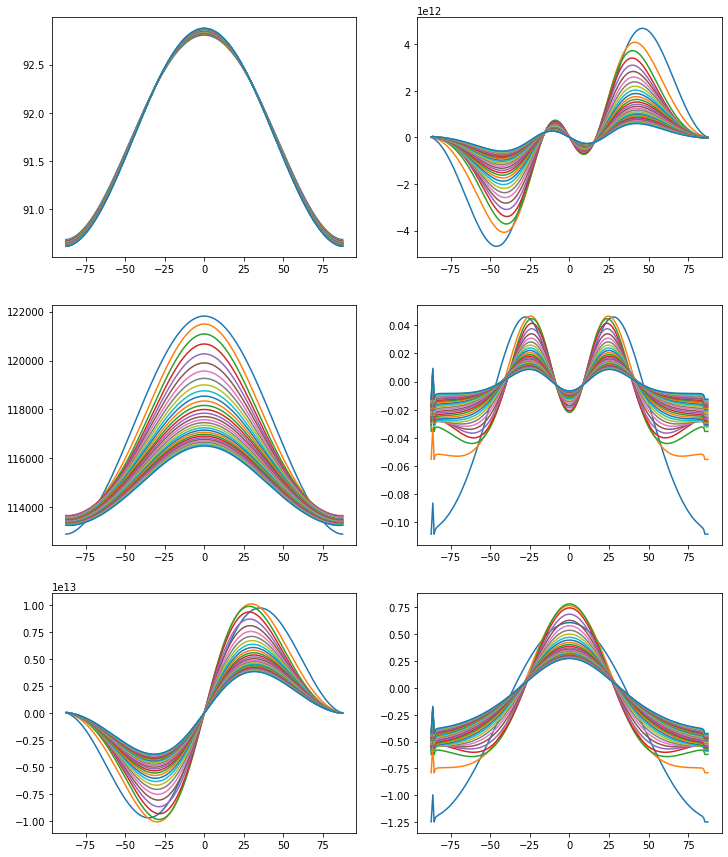

In [20]:
# Check diagnostic plots
fig = plt.figure(figsize = (12, 15))

for i in range(counter):
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(rad2deg(arcsin(xin)), results[i]["temp"])
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(rad2deg(arcsin(xin)), results[i]["latentFlux_W"])
    ax3 = plt.subplot(3, 2, 3)
    ax3.plot(rad2deg(arcsin(xin)), results[i]["MSE_J_kg"])
    ax4 = plt.subplot(3, 2, 4)
    ax4.plot(rad2deg(arcsin(xin)), results[i]["EminusP_m_yr"])
    ax5 = plt.subplot(3, 2, 5)
    ax5.plot(rad2deg(arcsin(xin)), results[i]["mseFlux_W"])
    ax6 = plt.subplot(3, 2, 6)
    ax6.plot(rad2deg(arcsin(xin)), results[i]["MSEFlux_Div"])

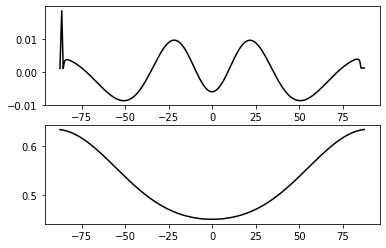

In [29]:
# Visualize net precipitation and relative humidity
plt.subplot(2, 1, 1)
plt.plot(rad2deg(arcsin(xin)), results[counter - 1]["EminusP_m_yr"], color = "black")
plt.subplot(2, 1, 2)
plt.plot(rad2deg(arcsin(xin)), RH(xin), color = "black")

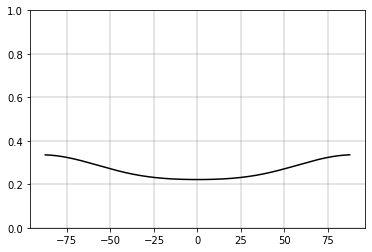

In [23]:
plt.plot(rad2deg(arcsin(xin)), RH(xin), color = "black")
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.grid(color = "gray", linestyle = "-", linewidth = 0.4)

### Test residuals of different orders of polynomials
This step allowed us to identify the fourth-order polynomial as that which would best approximate relative humidity thanks to its relatively low complexity.

In [ ]:
error_list = []

for i in range(2, 51):
    
    
    def RH(x):
        return 0.5*x**0

    init_guess = np.zeros(shape = (2, xin.size))
    sol = solve_bvp(MEBMfun, bc, xin, init_guess, verbose = 2)
    out = hydrofunc(x = xin, temp = sol.sol(xin)[0], coeff = 1.06)

    current = out["EminusP_m_yr"]
    rh = RH(xin)
    pos = out.loc[current > 0, "lat"]
    neg = out.loc[current <= 0, "lat"]

    rh[pos.index] -= metric
    rh[neg.index] += metric

    coefs = poly.polyfit(xin, rh, i)

    fit = poly.polyval(xin, coefs)

    error = sum((fit - rh)**2)
    error_list.append(error)

In [ ]:
plt.plot(range(2, 51), error_list)
plt.xlabel("Polynomial Degree", fontsize = 14)
plt.ylabel("Sum of Squared Error", fontsize = 14)
plt.title("Error of Polynomial Fits: Order 2 Through Order 50", fontsize = 15)
plt.scatter(14, error_list[14], color = "red", marker = "o", s = 60)
plt.text(15, 4.5, "Degree 14", color = "red")
plt.show()